# Physics-informed Neural Operator (PINO) for 2D wave eqautions

In [1]:
import os
from tqdm import tqdm
import numpy as np
import torch
from functorch import vmap, grad
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# local imports
from utils import GRF_Mattern, WaveEq2D, DataLoader2D
%matplotlib inline

def get_local_folder():
    return os.path.dirname(os.path.realpath(__file__))

## Input Parameters

In [13]:
dim = 2
n = 128
nx = n
ny = n
nt = 100
sub = 1
sub_t = 1
l = 0.1
L = 1.0
sigma = 1.0
nu = None
batch_size = 1
n_samples = 10
n_train = int(n_samples * 0.9)
n_test = n_samples - n_train
dt = 1.0e-4
save_int = int(1e-2/dt)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
grf = GRF_Mattern(dim, nx, length=L, nu=nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(n_samples)

In [15]:
x = torch.linspace(0, 1, nx + 1)[:-1]
y = torch.linspace(0, 1, nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')

## Gaussian Random Fields 2D

plotting few of the generated samples

In [16]:
def plot2D(X, Y, u, fig, ax):
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(6,5))
    
    c = ax.pcolormesh(X, Y, u, cmap='magma', shading='gouraud')
    fig.colorbar(c)
    
    return c, fig, ax


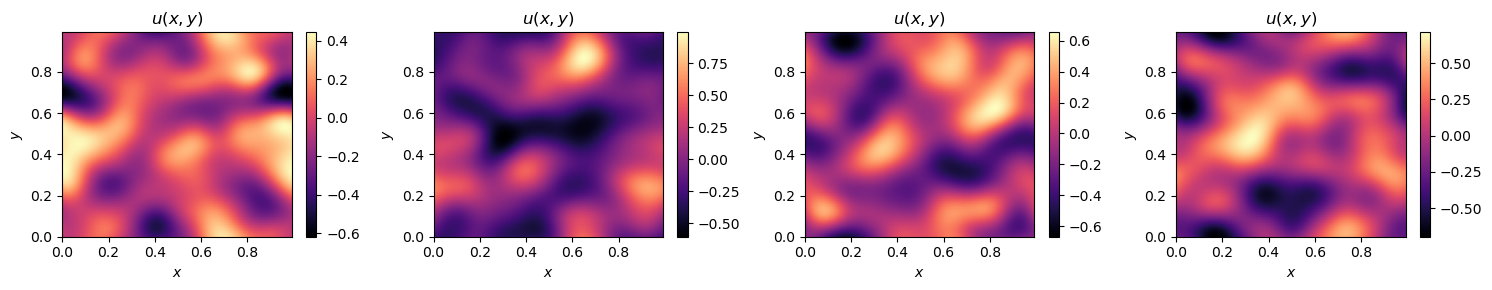

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

for i in range(4):
    tmp = U0[i].cpu().numpy()
    plot2D(X, Y, tmp, fig, ax[i])
    ax[i].set_title("$u(x,y)$")
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
plt.tight_layout()
plt.show()

In [18]:
wave_eq = WaveEq2D(Nx=nx, Ny=ny, dt=dt, device=device)
U = vmap(wave_eq.wave_driver, in_dims=(0, None))(U0, save_int)

In [19]:
u = U.cpu().float()
torch.isinf(u).any()

tensor(False)

In [20]:
# "data-128-1_1k.pt"
# u = torch.load(p)
u.shape

torch.Size([10, 101, 128, 128])

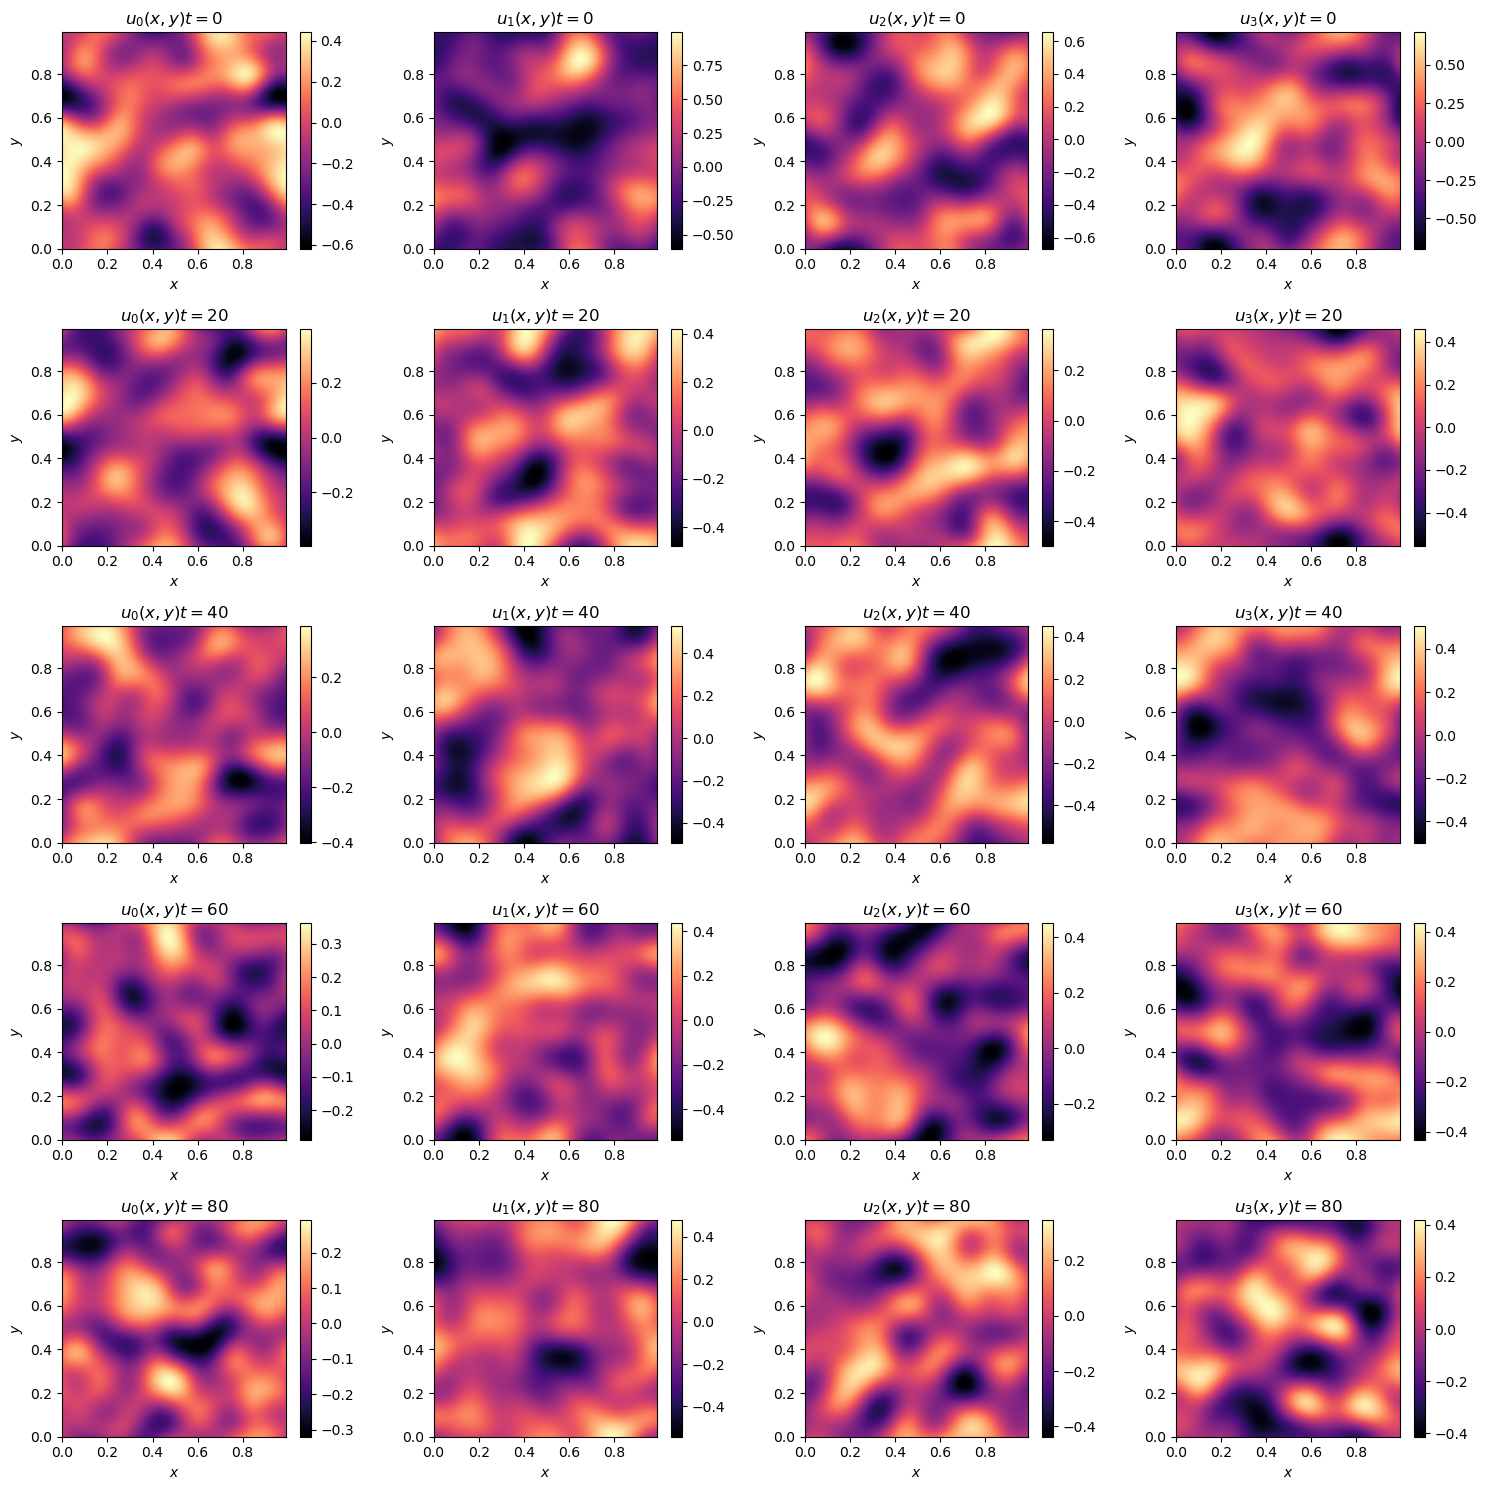

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
for j, v in enumerate(range(0, 100, 20), 0):
    for i in range(4):
#         tmp = U[i, v].cpu().numpy()
        tmp = u[i, v, ...]
        si = "{" + str(i) + "}"
        plot2D(X, Y, tmp, fig, ax[j, i])
        ax[j, i].set_title(f"$u_{si}(x,y) t={v}$")
        ax[j, i].set_xlabel('$x$')
        ax[j, i].set_ylabel('$y$')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


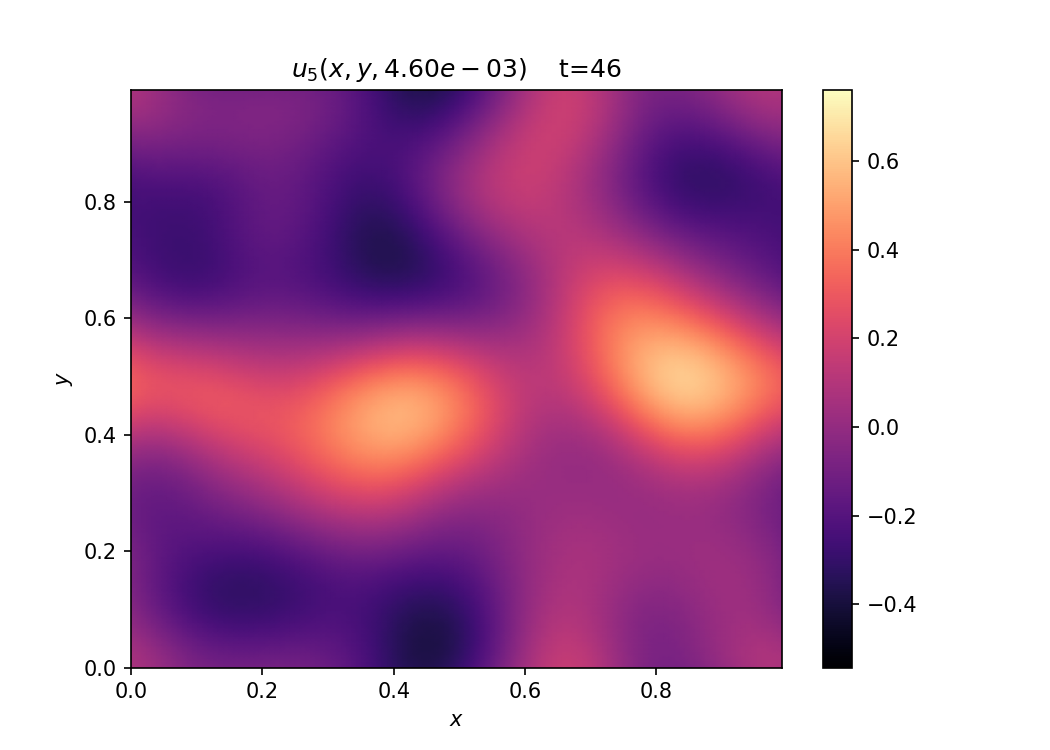

In [48]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots(figsize=(7, 5))
x = 5
stride = 2
temporal = U[x, ...].cpu().numpy()
ax.set_title(f"$u_{si}(x,y)$\tt={0}")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# def init():
c_img, _, _ = plot2D(X, Y, temporal[0], fig, ax)
#     return [c_img]

def update(i):
    c_img.set_array(temporal[i].ravel())
    t = f"{i * dt: .2e}"
    ax.set_title(f"$u_{x}(x,y,{t})$\tt={i}")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    return [c_img]

anim = animation.FuncAnimation(fig, update, interval=1000, blit=True, repeat_delay=None, frames=100)
p = os.path.join(get_local_folder(), "archives/wave-evolve.gif")
anim.save(p, writer="pillow", fps=60)
# plt.show()

In [12]:
dataset = DataLoader2D(u, nx, nt, sub, sub_t)
train_loader = dataset.make_loader(n_train, batch_size, start=0, train=True, only_data=True)
test_loader = dataset.make_loader(n_test, batch_size, start=n_train, train=False, only_data=True)

In [ ]:
train_loader[0]["coeff"].shape, train_loader[1]["sol"].shape

In [ ]:
# torch.permute(train_loader[0]["coeff"], (0, 4, 3, 1, 2))
torch.permute(train_loader[1]["sol"], (0, 3, 1, 2))

In [ ]:
from modulus.dataset import DictGridDataset
DictGridDataset?

In [12]:
save_int

100